<a href="https://colab.research.google.com/github/abhilash-git/learning/blob/main/amortization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from datetime import datetime,date,timedelta
import calendar
def getMonthwithIndex(index=0,date_in=datetime.now(),backward=False):
    days_in_month=0
    date_in = date_in.replace(day=1)
    for i in range(index):
      days_in_month = calendar.monthrange(date_in.year, date_in.month)[1]
      if backward:
        date_in=date_in - timedelta(days=days_in_month)
      else:
        date_in = date_in + timedelta(days=days_in_month)
    return date_in
    

In [2]:
!pip install numpy-financial
import numpy_financial as npf
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.float_format', lambda x: '%.5f' % x)

class Loan:
  def __init__(self, principle_amount, interest_in_year, period_in_years,starting_date=datetime.now()):
    self.starting_date = starting_date
    self.principle_amount = principle_amount
    self.interest_in_year = interest_in_year
    self.period_in_years = period_in_years
    self.column_names = ["MONTH", "STARTING_AMOUNT", "EMI_AMOUNT", "INTEREST_PAID", "PRINCIPLE_PAID", "LEFTOVER_PRINCIPLE"]
    self.df = pd.DataFrame(columns = self.column_names)
    self.orginal_df = pd.DataFrame(columns = self.column_names)
    self.emi_amount = npf.pmt((interest_in_year/100)/12, period_in_years*12, -principle_amount,0)
    self.Principle_paid=0
    self.Interest_paid=0
    self.advancePayments=[]

  def getPrincipleAmount(self):
      return self.principle_amount

  def setPrincipleAmount(self,amt):
    self.principle_amount = amt;

  def getDataFrame(self):
    return self.df

  def populateDateFrame(self):
    temp_emi = self.emi_amount
    period_in_months = int(round(self.period_in_years*12))
    print("called {}".format(period_in_months))
    for i in range(0,period_in_months):
      temp_list_one_row=[]
      # print(i)
      if self.getPrincipleAmount() < 1:
        print("Break")
        break;
      temp_list_one_row.append(getMonthwithIndex(i+1,self.starting_date).date())
      temp_list_one_row.append(self.getPrincipleAmount())
      self.Interest_paid=(self.getPrincipleAmount()*(self.interest_in_year/100)/12)
      if self.getPrincipleAmount() < self.emi_amount:
        print("EMI changed P={} I={}".format(self.getPrincipleAmount() , self.Interest_paid))
        self.emi_amount=self.getPrincipleAmount() + self.Interest_paid
      temp_list_one_row.append(self.emi_amount)
      temp_list_one_row.append(self.Interest_paid)
      self.Principle_paid = self.emi_amount - self.Interest_paid
      temp_list_one_row.append(self.Principle_paid)
      temp_list_one_row.append(self.getPrincipleAmount() - self.Principle_paid)
      self.setPrincipleAmount(self.getPrincipleAmount() - self.Principle_paid)

      # print(temp_list_one_row)
      self.df = self.df.append(pd.Series(temp_list_one_row, index=self.column_names), ignore_index=True)

    self.emi_amount = temp_emi 
    if self.orginal_df.empty:
      self.orginal_df = self.df.copy(deep=True)



  def adjustWithAdvancePayment(self, payment_date, paid_amount):
    temp_list1=[]
    self.period_in_years = round((self.df[self.df.MONTH > payment_date.date()].shape[0] -1 )/12, 5)
    print("Printing year {}".format(self.period_in_years))
    self.setPrincipleAmount(self.df[self.df.MONTH==payment_date.date()].LEFTOVER_PRINCIPLE.item())
    self.df.drop(self.df[self.df.MONTH> payment_date.date()].index, inplace=True)
    self.starting_date=getMonthwithIndex(1, payment_date)
    temp_list1.append(self.starting_date.date())
    temp_list1.append(self.getPrincipleAmount())
    temp_list1.append(self.emi_amount)
    self.Interest_paid=(self.getPrincipleAmount()*(self.interest_in_year/100)/12)
    temp_list1.append(self.Interest_paid)
    advance_paid = paid_amount - self.Interest_paid;
    self.advancePayments.append(advance_paid);
    print("Printing advance_paid {}".format(advance_paid))
    self.Principle_paid = (self.emi_amount - self.Interest_paid) + advance_paid;
    temp_list1.append(self.Principle_paid)
    temp_list1.append(self.getPrincipleAmount() - self.Principle_paid)
    self.setPrincipleAmount(self.getPrincipleAmount() - self.Principle_paid)
    # print(temp_list1)
    self.df = self.df.append(pd.Series(temp_list1, index=self.column_names), ignore_index=True)
    self.populateDateFrame()


  def getTrend(self,deviation=False):
    if not self.df.empty and not self.orginal_df.empty and deviation:
      deviation=True;
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(self.df.MONTH,self.df.STARTING_AMOUNT,color="blue")
    axes[1].plot(self.df.MONTH,self.df.PRINCIPLE_PAID,color="red")
    if deviation:
      axes[0].plot(self.orginal_df.MONTH,self.orginal_df.STARTING_AMOUNT,color="green")
      axes[1].plot(self.orginal_df.MONTH,self.orginal_df.PRINCIPLE_PAID,color="green")

    fig.tight_layout()

    plt.show()
    if deviation:
      print("You would have paid {} and with advance payment you paid {} ".format(self.orginal_df.EMI_AMOUNT.sum() , self.df.EMI_AMOUNT.sum()))
      print("Your saving is {} out of which advance principle paid is {}".format(self.orginal_df.EMI_AMOUNT.sum() - self.df.EMI_AMOUNT.sum(), 
                                                                       sum(self.advancePayments)))
      print("You saved {} in interest".format(self.orginal_df.EMI_AMOUNT.sum() - self.df.EMI_AMOUNT.sum() - sum(self.advancePayments)))



In [3]:
print("provide the date of Disbursement")
# year = int(input('Enter a year :'))
year=2020
# month = int(input('Enter a month :'))
month=5
# day = int(input('Enter a day :'))
day=5
date1 = datetime(year, month, day, 00, 00, 00, 00)
# print(date1)

provide the date of Disbursement


In [4]:
print("Provide details of Loan")
# amount = int(input('Enter principle amount :'))
amount=10000000
# rate = float(input('Enter the rate of interest accepted :'))
rate=12
# duration = int(input('Enter the duration in years :'))
duration=30

Provide details of Loan


In [5]:

obj1=Loan(amount,rate,duration,date1)


In [6]:
obj1.populateDateFrame()

called 360
EMI changed P=101842.83137877221 I=1018.428313787722


In [7]:
obj1.getDataFrame()

,MONTH,STARTING_AMOUNT,EMI_AMOUNT,INTEREST_PAID,PRINCIPLE_PAID,LEFTOVER_PRINCIPLE
0,2020-06-01,10000000,102861.25969,100000.00000,2861.25969,9997138.74031
1,2020-07-01,9997138.74031,102861.25969,99971.38740,2889.87229,9994248.86802
2,2020-08-01,9994248.86802,102861.25969,99942.48868,2918.77101,9991330.09701
3,2020-09-01,9991330.09701,102861.25969,99913.30097,2947.95872,9988382.13828
4,2020-10-01,9988382.13828,102861.25969,99883.82138,2977.43831,9985404.69997
...,...,...,...,...,...,...
355,2050-01-01,499230.05111,102861.25969,4992.30051,97868.95918,401361.09193
356,2050-02-01,401361.09193,102861.25969,4013.61092,98847.64877,302513.44315
357,2050-03-01,302513.44315,102861.25969,3025.13443,99836.12526,202677.31789
358,2050-04-01,202677.31789,102861.25969,2026.77318,100834.48651,101842.83138


In [8]:
obj1.adjustWithAdvancePayment(payment_date=datetime(2049, 1, 1, 00, 00, 00, 00),paid_amount=400000)

Printing year 1.25
Printing advance_paid 384861.009630582
called 15
EMI changed P=74104.0646621317 I=741.040646621317
Break


In [9]:
obj1.adjustWithAdvancePayment(payment_date=datetime(2049, 4, 1, 00, 00, 00, 00),paid_amount=400000)

Printing year 0.66667
Printing advance_paid 391445.0492725838
called 8
EMI changed P=69267.41580268908 I=692.6741580268908
Break


In [10]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
# obj1.getDataFrame()

In [11]:
# a.getDataFrame()[a.getDataFrame()[MONTH==datetime(2049, 1, 1, 00, 00, 00, 00).date()]]
# obj1.getDataFrame()[obj1.getDataFrame().MONTH> datetime(2021, 12, 1, 00, 00, 00, 00).date()]

In [12]:

obj2=Loan(amount,rate,duration,date1)

obj2.populateDateFrame()

# obj2.getDataFrame()



called 360
EMI changed P=101842.83137877221 I=1018.428313787722


In [13]:
obj2.adjustWithAdvancePayment(payment_date=datetime(2022, 1, 1, 00, 00, 00, 00),paid_amount=400000)

obj2.adjustWithAdvancePayment(payment_date=datetime(2022, 4, 1, 00, 00, 00, 00),paid_amount=400000)


Printing year 28.25
Printing advance_paid 300630.02088600426
called 339
EMI changed P=3606.742344931976 I=36.067423449319755
Break
Printing year 22.91667
Printing advance_paid 303802.53702187317
called 275
EMI changed P=60961.14120421618 I=609.6114120421618
Break


In [14]:

# pd.set_option("display.max_rows", None, "display.max_columns", None)
# obj2.getDataFrame()

# a.getDataFrame()[a.getDataFrame()[MONTH==datetime(2049, 1, 1, 00, 00, 00, 00).date()]]
# obj2.getDataFrame()[obj1.getDataFrame().MONTH> datetime(2021, 12, 1, 00, 00, 00, 00).date()]



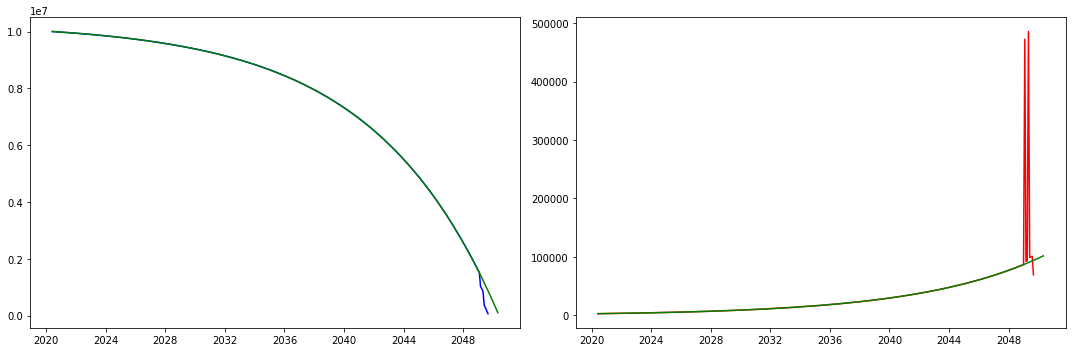

You would have paid 37030053.48931816 and with advance payment you paid 36174262.24204592 
Your saving is 855791.2472722456 out of which advance principle paid is 776306.0589031659
You saved 79485.18836907973 in interest


In [15]:
obj1.getTrend(deviation=True)

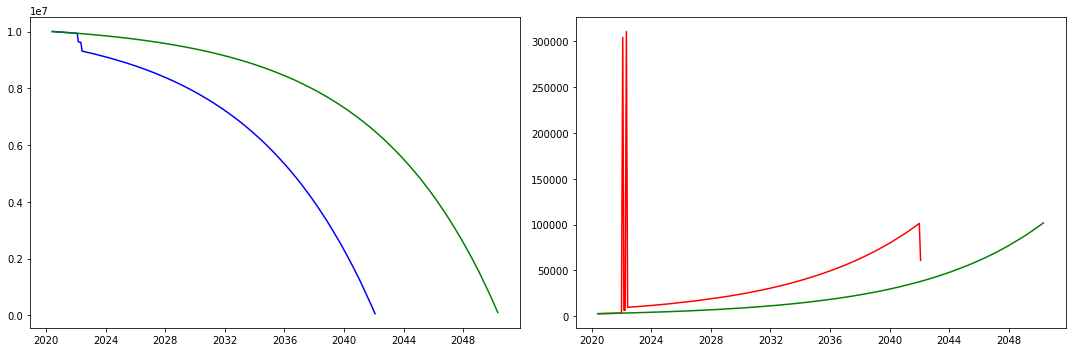

You would have paid 37030053.48931816 and with advance payment you paid 26805498.272679366 
Your saving is 10224555.216638796 out of which advance principle paid is 604432.5579078775
You saved 9620122.658730919 in interest


In [16]:
obj2.getTrend(deviation=True)